In [2]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import UninformativePrior, FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [3]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.SVHN(root='/scratch/pi49/datasets/svhn/', split='train',
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

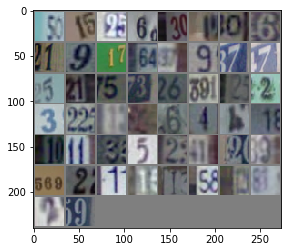

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [6]:
trainset[0][0].size()

torch.Size([3, 32, 32])

In [8]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
def gen_weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))
        x = x.squeeze()

        return x


In [9]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 3, 32, 32])
torch.Size([10])


In [10]:
from bgan.bgan import BGAN

In [11]:
batch_size = 50
z_dim = 100

In [17]:
# prior = UninformativePrior()
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
# gen.apply(weight_init)
gen.apply(gen_weight_init)
disc.apply(weight_init)
bgan = BGAN(gen, disc, prior, alpha=.9, eta=0.00001, disc_lr = 0.00002, gen_observed=20000, MAP=False, cuda=True)
samples = []

Moving generator and discriminator to GPU


In [18]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 18.0903
torch.Size([512]) 0.0
torch.Size([512]) 12.6487
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 28.964
torch.Size([256]) 0.0
torch.Size([256]) 9.18784
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 14.4824
torch.Size([128]) 0.0
torch.Size([128]) 6.23887
torch.Size([128]) 0.0
torch.Size([128, 3, 4, 4]) 1.55873
torch.Size([3]) 0.0


## Training

In [19]:
num_samples = 10

In [ ]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(100):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 10.1187 0.707556
0
	 0.100348 2.00275
1
	 0.00185355 11.5665
2
	 0.000336558 8.09392
3
	 0.00677305 5.56026
4
	 0.0105172 5.15437
5
	 0.0124289 14.541
6
	 0.0297809 4.062
7
	 3.8146 -0.748879
8
	 0.00597367 5.50909
9
	 0.00227032 6.19511
10
	 0.012798 5.48102
11
	 0.00166235 12.1305
12
	 0.0105599 6.13377
13
	 6.21808 -0.492417
14
	 0.00950309 5.70407
15
	 6.67573 0.580323
16
	 0.0925454 4.2402
17
	 0.0015581 9.28415
18
	 0.977824 1.72291
19
	 10.8683 -0.164799
20


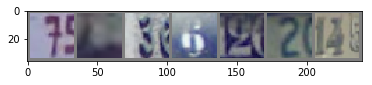

In [78]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [79]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [80]:
# samples = bgan.sample(100).cpu().data.numpy()

In [81]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [82]:
samples_arr.shape

(1580, 3, 32, 32)

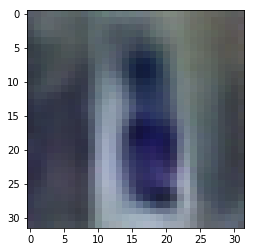

In [83]:
plt.imshow((samples_arr[-1] / 2 + 0.5).transpose(1, 2, 0))

In [84]:
np.max(batch.numpy())

0.93725491

In [85]:
samples_arr.shape

(1580, 3, 32, 32)

In [89]:
# np.save('samples/bgan_svhn_samples.npy', samples_arr)

(-0.5, 341.5, 5373.5, -0.5)

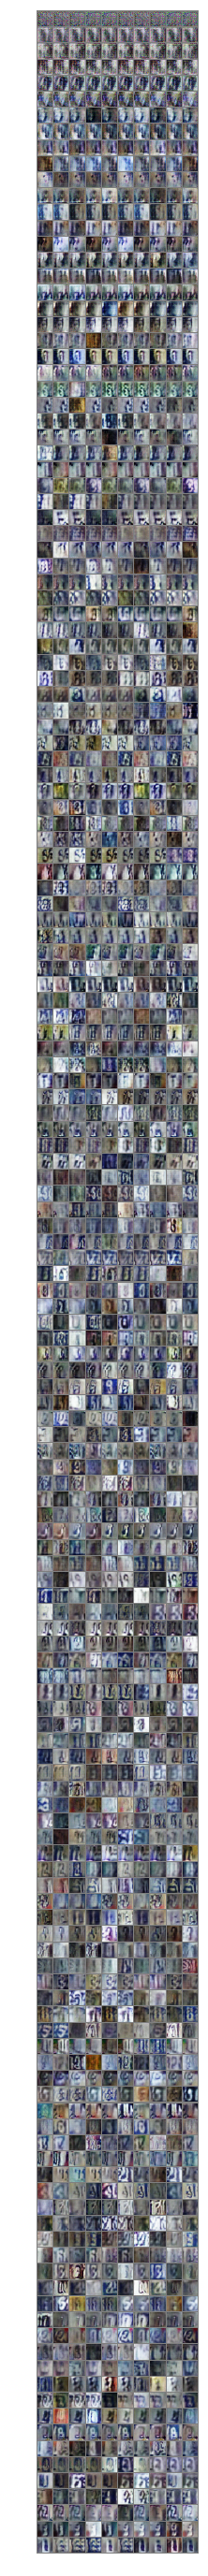

In [88]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[:]), nrow=10))
plt.axis('off')

In [231]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())

In [232]:
sample_probs

Variable containing:
1.00000e-20 *
  0.4522
  0.1922
  0.3036
  0.4392
  0.1848
  1.5164
  0.4982
  0.8398
  0.2858
  0.6793
  0.4012
  0.1287
  0.2649
  0.5890
  0.1416
  1.2532
  1.0863
  0.2694
  1.7121
  0.4283
  0.2509
  0.4113
  0.1057
  0.9219
  1.0674
  0.3448
  0.4309
  0.5785
  0.2870
  1.4667
  0.4478
  0.9585
  0.5954
  0.2946
  0.1166
  0.2767
  0.2845
  0.4299
  2.9327
  0.2198
  0.3216
  0.1603
  0.1138
  0.4855
  0.3680
  0.4580
  1.5890
  2.3397
  0.3754
  0.5708
  0.4973
  0.1367
  1.0316
  0.1913
  0.3745
  0.3049
  0.8399
  1.8432
  0.2965
  0.2935
  0.5819
  0.5188
  0.2772
  0.2128
  2.0933
  0.4892
  0.2451
  0.0923
  0.9113
  0.2953
  0.4009
  0.8969
  0.1752
  0.1792
  0.6155
  0.2812
  0.1118
  1.6429
  0.6773
  1.7840
  0.4768
  0.4536
  0.7689
  0.7097
  0.4027
  0.3429
  0.4573
  0.0868
  0.2309
  1.5800
  0.2369
  0.5229
  0.9087
  0.4023
  1.7018
  0.8112
  0.0878
  0.1963
  0.6600
  0.8844
[torch.cuda.FloatTensor of size 100 (GPU 0)]

In [233]:
disc(Variable(batch).cuda())

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 50 (GPU 0)]